In [24]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook', font_scale=1.3)

import itertools as it
from collections import Counter, defaultdict, deque

import sys
from analysis_utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
VERSION = 'c1.0'
data = get_data(VERSION, '../experiment/data')
ids = pd.read_csv(f'../experiment/data/human_raw/{VERSION}/identifiers.csv').set_index('pid')
pdf = data['participants']
mdf = data['mouselab-mdp']
tdf = mdf.query('block == "test"').copy()

tdf.trial_index -= tdf.trial_index.min()
tdf.trial_index = tdf.trial_index.astype(int)
tdf.trial_id = tdf.trial_id.astype(int)

pdf['total_time'] = data['survey'].time_elapsed / 60000

def extract(q):
    return list(map(int, q['click']['state']['target']))

tdf['clicks'] = tdf.queries.apply(extract)
tdf['n_clicks'] = tdf.clicks.apply(len)
pdf['n_clicks'] = tdf.groupby('pid').n_clicks.mean()
pdf['score'] = tdf.groupby('pid').score.sum()

(pdf.n_clicks == 0).mean()

AttributeError: 'DataFrame' object has no attribute 'time_elapsed'

In [28]:
tdf.score.mean()

5.106611570247934

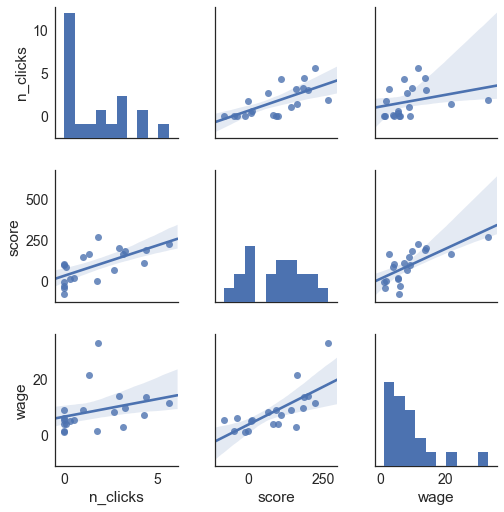

In [3]:
tdf['trial_time'] = tdf.rt.apply(sum) / 1000 / 60 / 60
tdf['bonus'] = tdf['score'] * 0.01
tdf['value'] = tdf.bonus - 7 * tdf.trial_time

pdf['pay'] = (1 + pdf['bonus'].clip(0))
pdf['wage'] = 60 * pdf.pay / pdf.total_time

sns.pairplot(pdf[['n_clicks', 'score', 'wage']], kind='reg')

In [26]:
mdf['thinking'] = mdf['rt'].apply(get(0))
mdf.query('thinking < @mdf.thinking.quantile(0.95)').groupby(['block']).thinking.mean() / 1000

block
test                  3.564370
train_basic           5.290338
train_final           4.498299
train_hidden          2.878761
train_inspect_cost    4.489412
train_inspector       6.243439
Name: thinking, dtype: float64

In [36]:
pdf.bonus.median()

1.68

In [29]:
x = mdf.groupby(['pid', 'block']).time_elapsed
(x.max() - x.min()).mean(level=1) / 60000

block
test                  4.108341
train_basic           1.714753
train_final           0.695385
train_hidden          0.445907
train_inspect_cost    0.792056
train_inspector       1.037633
Name: time_elapsed, dtype: float64

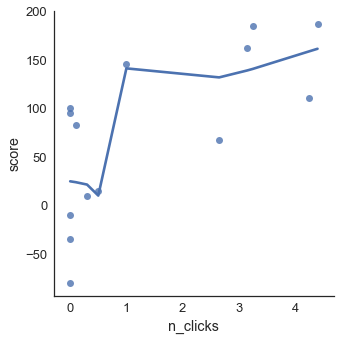

In [27]:
sns.lmplot('n_clicks', 'score', data=pdf, lowess=1)

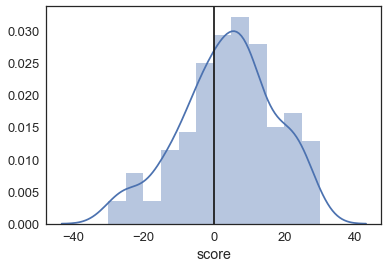

In [31]:
sns.distplot(tdf.score)
plt.axvline(0, c='k')

# Python stats

In [20]:
import statsmodels.formula.api as smf
model = smf.ols('score ~ trial_index', data=rdf).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.2739
Date:                Wed, 17 Jan 2018   Prob (F-statistic):              0.601
Time:                        16:02:32   Log-Likelihood:                -2506.6
No. Observations:                 520   AIC:                             5017.
Df Residuals:                     518   BIC:                             5026.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      25.7907      2.541     10.151      0.000      20.799      30.782
trial_index    -0.1197      0.229     -0.523      0.601      -0.569       0.329
==============================================================================
Omnibus:                       23.216   Durbin-Watson:                   1.707
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               27.111
Skew:                          -0.453   Prob(JB):                     1.30e-06
Kurtosis:                       3.657   Cond. No.                         21.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# R stats

In [6]:
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
pandas2ri.activate()
from rpy2.robjects.conversion import ri2py
%load_ext rpy2.ipython

In [8]:
rdf = df2r(tdf, ['trial_index', 'score'])

In [22]:
%%R -i rdf
m = lm(score ~ trial_index, data=rdf)
summary(m)


Call:
lm(formula = score ~ trial_index, data = rdf)

Residuals:
     Min       1Q   Median       3Q      Max 
-117.073  -17.312    2.346   21.598   75.047 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  25.7907     2.5408  10.151   <2e-16 ***
trial_index  -0.1197     0.2286  -0.523    0.601    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 30.06 on 518 degrees of freedom
Multiple R-squared:  0.0005286,	Adjusted R-squared:  -0.001401 
F-statistic: 0.2739 on 1 and 518 DF,  p-value: 0.6009



In [5]:
def load_sims():
    for f in glob('data/exp_sim/constant_high_1/*.pkl'):
        df = pd.read_pickle(f)
        yield df
        
sdf = pd.concat(load_sims())
opt_util = sdf.groupby('trial_id').util.mean()

In [16]:
rand_pol = MouselabPolicy({'term_reward': 0})
from evaluation import evaluate

NameError: name 'Agent' is not defined

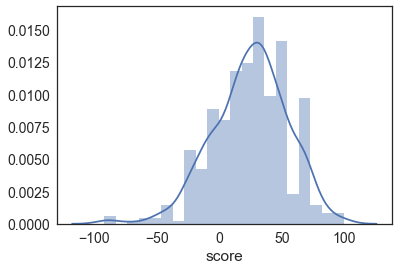

In [19]:
sns.distplot(tdf.score)

In [13]:
opt_util[tdf.trial_id].mean()

33.473653846153844

In [29]:
joblib.dump(list(zip(tdf.trial_id, tdf.clicks)), 'data/empirical_clicks.pkl')

[autoreload of train_policies failed: Traceback (most recent call last):
  File "/usr/local/lib/miniconda3/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 246, in check
    superreload(m, reload, self.old_objects)
  File "/usr/local/lib/miniconda3/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 369, in superreload
    module = reload(module)
  File "/usr/local/lib/miniconda3/lib/python3.6/imp.py", line 315, in reload
    return importlib.reload(module)
  File "/usr/local/lib/miniconda3/lib/python3.6/importlib/__init__.py", line 166, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 618, in _exec
  File "<frozen importlib._bootstrap_external>", line 674, in exec_module
  File "<frozen importlib._bootstrap_external>", line 781, in get_code
  File "<frozen importlib._bootstrap_external>", line 741, in source_to_code
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "bin/trai

['data/empirical_clicks.pkl']

In [41]:
def empirical_state_actions():
    for trial_id, clicks in zip(tdf.trial_id, tdf.clicks):
        if trial_id == 24987:
            continue # collision!
        env = make_env('constant_high', ground_truth=trials[trial_id])
        pol = FixedPlanPolicy([*clicks, env.term_action])
        trace = run_episode(pol, env)
        yield from zip(trace['states'], trace['actions'])

In [10]:
pol = lc_policy([-40, 1, 0, 0])

def yoked_returns(trial_id, clicks):
    env = make_env('constant_high', ground_truth=trials[trial_id])
    for click in clicks:
        yield sum(run_episode(pol, env)['rewards'])
        env.reset()
        env.init = env.step(click)[0]
 

In [12]:
from toolz import partition_all, concat
args = 
chunk_size = 10
chunks = partition_all(chunk_size, args)
def one(chunk):
    return sum(concat(yoked_returns(*args) for args in chunk))

one(next(chunks))